In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [3]:
import glob
import os
import matplotlib.pyplot as plt

In [4]:
import zipfile

zip_files_input = ['test1', 'train']

for z in zip_files_input:
    with zipfile.ZipFile("../input/dogs-vs-cats/{}.zip".format(z), 'r') as i:
        i.extractall(".")
        print("{} unzipped".format(z))

test1 unzipped
train unzipped


In [7]:
IMAGE_FOLDER_PATH = "../working/train"
FILE_NAMES = os.listdir("../working/train")
WIDTH = 150
HEIGHT = 150

targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

df=pd.DataFrame()
df['image_path']=full_paths
df['label']=targets
df.head(10)

,image_path,label
0,../working/train/cat.3705.jpg,cat
1,../working/train/dog.11629.jpg,dog
2,../working/train/cat.5232.jpg,cat
3,../working/train/dog.3867.jpg,dog
4,../working/train/cat.12206.jpg,cat
5,../working/train/dog.8574.jpg,dog
6,../working/train/cat.7438.jpg,cat
7,../working/train/cat.9845.jpg,cat
8,../working/train/dog.9304.jpg,dog
9,../working/train/dog.9453.jpg,dog


In [8]:
print("Shape of training data: ", df.shape)
print("Number of cat images: ", len(df[df['label']=='cat']))
print("Number of dog images: ", len(df[df['label']=='dog']))

Shape of training data:  (25000, 2)
Number of cat images:  12500
Number of dog images:  12500


### Training data has a net total of 25,000 images of cats and dogs i.e. 12,500 of Cats and 12,500 of Dogs

## Data Visualization in form of Gallery

In [51]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="both"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    
    rng_state = np.random.get_state()
    np.random.shuffle(full_paths)
    np.random.set_state(rng_state)
    np.random.shuffle(targets)
    
    for path, target in zip(full_paths, targets):
        # if target doesn't match the label to show (i.e. dog or cat) we can continue
        # we shall not continue is label to show is 'both'
        if target!=show and show!="both":
            continue
        
        counter=counter+1
        
        # break after displaying 100 images
        if counter%100==0:
            break
        
        
        # load image from the path and fix its size
        #print("Image path: ", path)
        img = load_img(path, target_size = (WIDTH, HEIGHT))
        # convert image jpeg to numpy array -- very important step for processing
        img = img_to_array(img)
        
        ## now we need to stack some images horizontally and some wertically so as to form a 10*10 grid
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title={"both":"Dogs and Cats",
          "cat": "Cats",
          "dog": "Dogs"}
    plt.title("100 samples of {} of the dataset".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

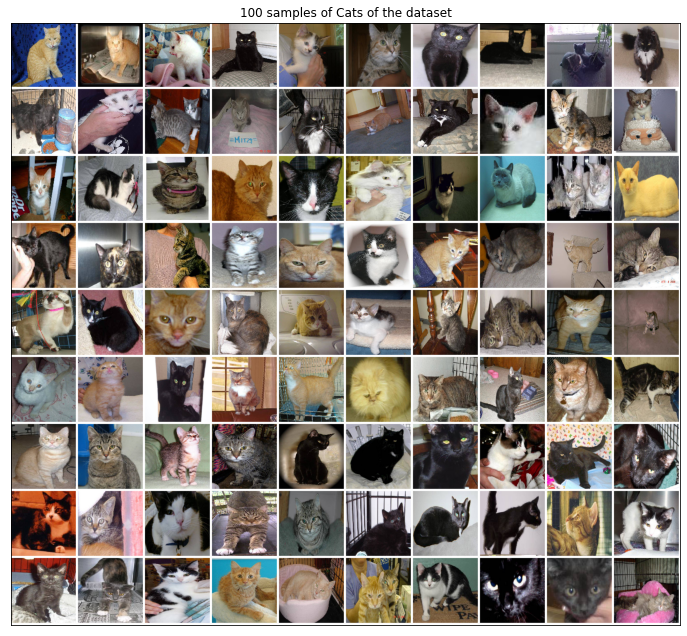

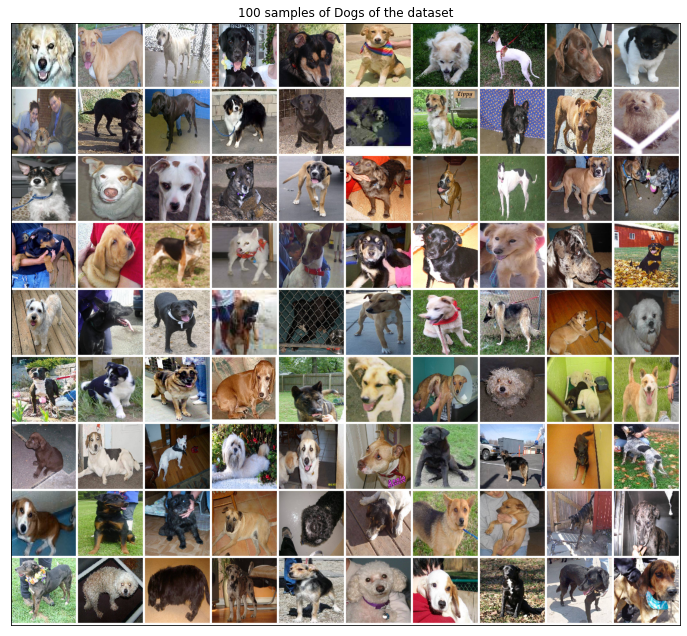

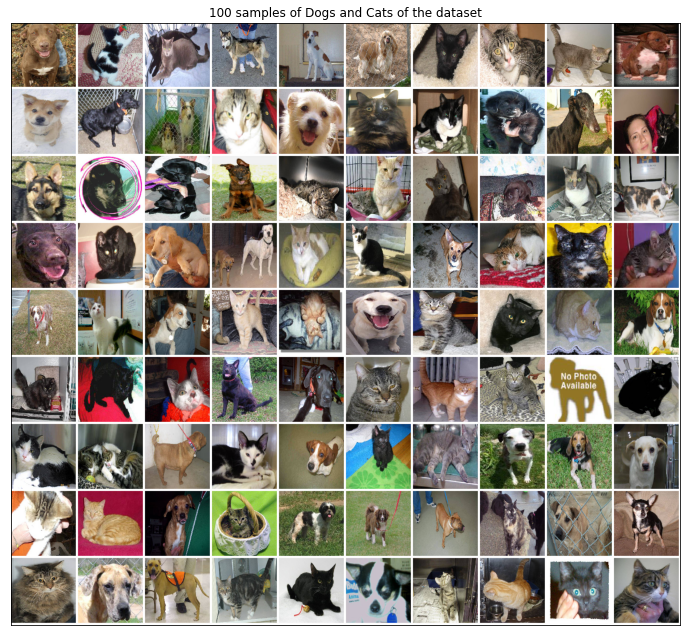

In [53]:
show_gallery('cat')
show_gallery('dog')
show_gallery('both')

## CNN

In [1]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [11]:
######### CNN Model Architecture ##########

model_cnn = models.Sequential()

## Conv2D structure:
# filters/features like edges, corners, etc would be kept as 32
# kernel size -- 2D convolution window
# activation function Relu
# input shape is image shape (width, height, number of channels  -- in this case 3: RGB)

model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
# Batch normalization is used to normalize/standardize input/output of layers in a Sequential model to make them independent
model_cnn.add(layers.BatchNormalization())
# Max Pooling helps to account for distortions/rotation/changes in the image -- this is different from padding
model_cnn.add(layers.MaxPooling2D((2,2)))
# dropout - to prevent overfitting -- randomly dropping nodes while backprop during training 
model_cnn.add(layers.Dropout(0.25))

model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Dropout(0.25))

model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Dropout(0.25))

model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Dropout(0.25))

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(512, activation="relu"))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(1, activation="sigmoid"))

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 69, 69, 32)       